# Setup pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!cp /content/drive/MyDrive/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark as spark

print(spark.__version__)

3.1.1


# Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, lag,to_date, array, when, collect_list
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

import matplotlib.pyplot as plt

import csv
import os
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

# Req 1: Khuyến nghị sản phẩm với Collaborative Filtering

## Process

In [ ]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Collaborative Filtering Recommendation System") \
    .getOrCreate()

# Load the dataset
data = spark.read.csv("ratings2k.csv", header=True, inferSchema=True)

# Divide the dataset into training and test sets (70:30 ratio)
(training, test) = data.randomSplit([0.7, 0.3], seed=123)
# Initialize lists to store MSE values and number of similar users
mse_values = []
similar_users_values = list(range(10, 21))

In [ ]:
for num_similar_users in similar_users_values:
    # Train ALS model
    als = ALS(maxIter=5, regParam=0.01, userCol="user", itemCol="item", ratingCol="rating",
              coldStartStrategy="drop", rank=10, numUserBlocks=10, numItemBlocks=10, implicitPrefs=False,
              alpha=1.0, seed=None, checkpointInterval=10,
              intermediateStorageLevel="MEMORY_AND_DISK", finalStorageLevel="MEMORY_AND_DISK",
              nonnegative=False)
    model = als.fit(training)

    # Generate predictions
    predictions = model.transform(test)

    # Evaluate the model
    evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
    mse = evaluator.evaluate(predictions)

    # Store MSE value
    mse_values.append(mse)

Exception ignored in: <function JavaWrapper.__del__ at 0x7a36621fae60>
Traceback (most recent call last):
  File "/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'ALS' object has no attribute '_java_obj'
Exception ignored in: <function JavaWrapper.__del__ at 0x7a36621fae60>
Traceback (most recent call last):
  File "/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'ALS' object has no attribute '_java_obj'
Exception ignored in: <function JavaWrapper.__del__ at 0x7a36621fae60>
Traceback (most recent call last):
  File "/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'ALS' object has no attribute '_java_obj'


In [ ]:
mse_values

[4.174544420497629,
 4.174544420497629,
 4.174544420497629,
 4.174544420497629,
 4.174544420497629,
 4.174544420497629,
 4.174544420497629,
 4.174544420497629,
 4.174544420497629,
 4.174544420497629,
 4.174544420497629]

In [ ]:
test.drop('rating')

DataFrame[index: int, user: int, item: int]

In [ ]:
als = ALS(rank=10, seed=0)
als.setMaxIter(5)
als.getMaxIter()
als.setRegParam(0.1)
als.getRegParam()
als.clear(als.regParam)
model = als.fit(training)
model.getBlockSize()

4096

In [ ]:
model.setPredictionCol("newPrediction")
model.userFactors.orderBy("id").collect()

In [ ]:
predictions = sorted(model.transform(test).collect(), key=lambda r: r[0])
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="newPrediction")

In [ ]:
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

In [ ]:
predictions

# Req 2: Dự đoán giá chứng khoán.

In [ ]:
class PredictHVN:
    def __init__(self, path):
        self.data = spark.read.option("header", "true").csv(path)

    def create_fluctuation(self):
        self.data = self.data.withColumn("Ngay", to_date("Ngay", "dd/MM/yyyy")).orderBy(col("Ngay"))
        # Calculate the fluctuation
        window_spec = Window.orderBy(col("Ngay"))
        self.data = self.data.withColumn("Fluctuation", (col("HVN") - lag("HVN", 1).over(window_spec)) / lag("HVN", 1).over(window_spec))
        # Fill null values with 0 for the first row in Fluctuation column
        self.data = self.data.withColumn("Fluctuation", when(col("Fluctuation").isNull(), 0).otherwise(col("Fluctuation")))

    def create_fluctuation_DF(self):
        # Create a window specification for the last 5 days
        vector_window_spec = Window.orderBy(col("Ngay")).rowsBetween(-4, 0)
        # Collect the fluctuation values of the past 5 days into an array
        self.data = self.data.withColumn("VectorFluctuation", collect_list("Fluctuation").over(vector_window_spec))

    def plot_mse_chart(self, train_mse, test_mse):
        # Plotting MSE values
        labels = ['Training', 'Test']
        mse_values = [train_mse, test_mse]

        x = np.arange(len(labels))
        width = 0.35

        fig, ax = plt.subplots()
        rects = ax.bar(x, mse_values, width, label='MSE')

        ax.set_ylabel('MSE')
        ax.set_title('MSE on Training and Test Dataset')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{}'.format(round(height, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects)

        fig.tight_layout()

        plt.show()

    def predict(self):
        # Convert 'HVN' column to float type
        data = self.data.withColumn("HVN", col("HVN").cast("float"))
        # VectorAssembler to combine features into a single vector
        assembler = VectorAssembler(inputCols=["HVN"], outputCol="features")
        # Transform the data
        data = assembler.transform(data)
        # Select the features and the target variable
        data = data.select("Ngay", "HVN", "Fluctuation", "features")
        # Split the data into training and testing sets (80% training, 20% testing)
        train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)
        # Create a Linear Regression model
        lr = LinearRegression(featuresCol="features", labelCol="Fluctuation")
        # Train the model
        lr_model = lr.fit(train_data)
        # Make predictions on the training data
        train_predictions = lr_model.transform(train_data)
        # Calculate MSE on training data
        train_mse = train_predictions.selectExpr("pow(Fluctuation - prediction, 2) as squared_error").agg({"squared_error": "avg"}).collect()[0][0]
        # Make predictions on the test data
        test_predictions = lr_model.transform(test_data)
        # Calculate MSE on test data
        test_mse = test_predictions.selectExpr("pow(Fluctuation - prediction, 2) as squared_error").agg({"squared_error": "avg"}).collect()[0][0]
        self.plot_mse_chart(train_mse, test_mse)

    def run(self):
        self.create_fluctuation()
        self.create_fluctuation_DF()
        self.predict()

TypeError: Invalid argument, not a string or column: 0.000582851344851675 of type <class 'numpy.float64'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

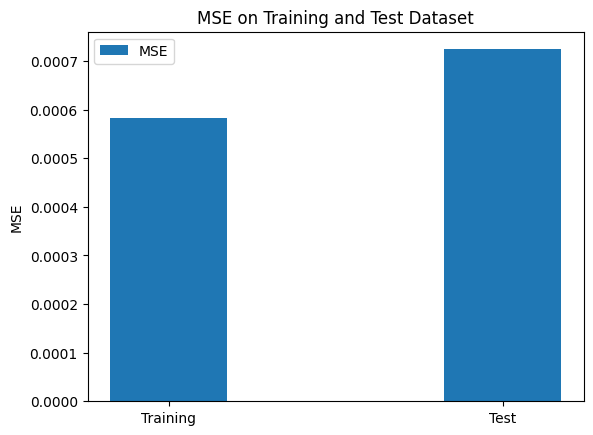

In [ ]:
path = "/content/stockHVN2022.csv"
PredictHVN(path).run()